In [1]:
# Import needed libraries 

import pandas as pd 
import os
import datetime
from datetime import timedelta
import numpy as np 
from scipy.signal import argrelextrema
import alpaca_trade_api as tradeapi 
import matplotlib.pyplot as plt 
import matplotlib.dates as mpdates
from mplfinance.original_flavor import candlestick_ohlc
from dotenv import load_dotenv
from itertools import islice

In [2]:
# Load .env file

load_dotenv()

True

In [3]:
# Set Alpaca API key and secret
ALPACA_API_KEY = os.getenv("ALPACA_API_KEY")
ALPACA_SECRET_KEY = os.getenv("ALPACA_SECRET_KEY")
ALPACA_ENDPOINT_KEY = os.getenv("ALPACA_END_POINT")


# Create the Alpaca API object
api = tradeapi.REST(
    ALPACA_API_KEY,
    ALPACA_SECRET_KEY,
    api_version="v2",
    base_url= ALPACA_ENDPOINT_KEY
)

In [4]:
# Parameters for Stock Data from Alpacas
# Establish time frame (5 minute)

time_frame = "5min"

# Identify what stock symbol is trading

stock_symbol = "QQQ"

# Identify what start date to begin data analysis
# JAN 27 27 2021 GameStop event (GME) are we still doing this?

start_date = pd.Timestamp("2021-02-08", tz="America/New_York").isoformat()

# Identify what end date to finalize data analysis

end_date = pd.Timestamp("2021-02-09", tz="America/New_York").isoformat()

In [5]:
print(start_date)
print(end_date)

2021-02-08T00:00:00-05:00
2021-02-09T00:00:00-05:00


In [6]:
# Function to call daily stock data

def get_stock_data(api, stock_symbol, time_frame, start_date, end_date):
    
    # Assuming api.get_bars returns a DataFrame with a 'df' attribute
    
    stock_data = api.get_bars(
        stock_symbol, 
        time_frame, 
        start=start_date, 
        end=end_date
        ).df
    return stock_data

stock_data = get_stock_data(api, stock_symbol, time_frame, start_date, end_date)

# Displays the information pulled for working through code

stock_data.info()
display(stock_data.head())
display(stock_data.tail())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 191 entries, 2021-02-08 09:00:00+00:00 to 2021-02-09 00:55:00+00:00
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   close        191 non-null    float64
 1   high         191 non-null    float64
 2   low          191 non-null    float64
 3   trade_count  191 non-null    int64  
 4   open         191 non-null    float64
 5   volume       191 non-null    int64  
 6   vwap         191 non-null    float64
dtypes: float64(5), int64(2)
memory usage: 11.9 KB


,close,high,low,trade_count,open,volume,vwap
timestamp,,,,,,,
2021-02-08 09:00:00+00:00,332.52,332.60,332.50,43,332.53,7077,332.551844
2021-02-08 09:05:00+00:00,332.58,332.62,332.47,26,332.53,5163,332.501669
2021-02-08 09:10:00+00:00,332.63,332.67,332.63,7,332.64,2992,332.638663
2021-02-08 09:15:00+00:00,332.60,332.65,332.56,15,332.60,2065,332.591991
2021-02-08 09:20:00+00:00,332.62,332.62,332.57,8,332.57,783,332.600204


,close,high,low,trade_count,open,volume,vwap
timestamp,,,,,,,
2021-02-09 00:35:00+00:00,333.01,333.08,333.0100,11,333.0800,1377,333.047385
2021-02-09 00:40:00+00:00,332.96,333.04,332.9500,21,333.0400,2360,332.975555
2021-02-09 00:45:00+00:00,332.96,333.00,332.9099,18,332.9099,1539,332.960845
2021-02-09 00:50:00+00:00,333.20,333.25,333.0200,57,333.0600,9801,333.089948
2021-02-09 00:55:00+00:00,333.23,333.34,333.1500,101,333.2500,17352,333.245305


In [7]:
# Function to prepare daily stock data to identify double top/bottom patterns and prepare for targets
# Includes establishing a polynomial fit and assigning new columns for localized min/max

# Polynomial Degree

polynomial_degree = 75

def polynomial_min_max_fit(stock_data, polynomial_degree):
    
    min_length = min(len(stock_data.index), len(stock_data['close']))
    x_data = np.arange(min_length)

    # Polynomial fitting
    polynomial_coefficients_open = np.polyfit(x_data, stock_data['open'][:min_length], polynomial_degree)
    polynomial_coefficients_high = np.polyfit(x_data, stock_data['high'][:min_length], polynomial_degree)
    polynomial_coefficients_low = np.polyfit(x_data, stock_data['low'][:min_length], polynomial_degree)
    polynomial_coefficients_close = np.polyfit(x_data, stock_data['close'][:min_length], polynomial_degree)

    # Evaluate the polynomial for plotting
    y_polynomial_open = np.polyval(polynomial_coefficients_open, x_data)
    y_polynomial_high = np.polyval(polynomial_coefficients_high, x_data)
    y_polynomial_low = np.polyval(polynomial_coefficients_low, x_data)
    y_polynomial_close = np.polyval(polynomial_coefficients_close, x_data)

    # Identify local extrema for polynomial fit data (minima and maxima)
    local_poly_minima = argrelextrema(y_polynomial_close, np.less, order=5)[0]
    local_poly_maxima = argrelextrema(y_polynomial_close, np.greater, order=5)[0]

    # Convert the close price polynomial fit data into a dataframe
    # This is done for OHLC poly fit data

    poly_df = pd.DataFrame(y_polynomial_open)
    columns = ['poly_fit_open']
    poly_df.columns = columns
    poly_df = poly_df.assign(poly_fit_high = y_polynomial_high)
    poly_df = poly_df.assign(poly_fit_low = y_polynomial_low)
    poly_df = poly_df.assign(poly_fit_close = y_polynomial_close)

    # Reset the index of the original updated ticker dataframe to concat with the polynomial dataframe that does not include a timeseries
    # This will ensure that the indexed intergers of the ploynomial fit align with the time each data point corresponds to

    updated_stock_data = stock_data.reset_index()
    updated_stock_data = pd.concat([updated_stock_data, poly_df], axis='columns', join='inner')
    updated_stock_data.head()

    # Add minima and maxima column to the DataFrame

    updated_stock_data["minima"] = 0
    updated_stock_data["maxima"] = 0
    updated_stock_data.head()

    # Mark rows with local minima as 1 in the 'minima' column

    for index in local_poly_minima:
        updated_stock_data.at[index, 'minima'] = -1

    for index in local_poly_maxima:
        updated_stock_data.at[index, "maxima"] = 1

    # Create Target Columns - Double Top Target & Double Bottom Target
        
    updated_stock_data["dbl_top_target"] = 0
    updated_stock_data["dbl_bot_target"] = 0

    return updated_stock_data, min_length, y_polynomial_close, local_poly_minima, local_poly_maxima

updated_stock_data, min_length, y_polynomial_close, local_poly_minima, local_poly_maxima = polynomial_min_max_fit(stock_data,polynomial_degree)

c:\Users\JamesDavidson\Anaconda3\envs\mlenv\lib\site-packages\numpy\lib\polynomial.py:667: RuntimeWarning: overflow encountered in multiply
  scale = NX.sqrt((lhs*lhs).sum(axis=0))
c:\Users\JamesDavidson\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:49: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
C:\Users\JamesDavidson\AppData\Local\Temp\ipykernel_33436\490055435.py:14: RankWarning: Polyfit may be poorly conditioned
  polynomial_coefficients_open = np.polyfit(x_data, stock_data['open'][:min_length], polynomial_degree)
C:\Users\JamesDavidson\AppData\Local\Temp\ipykernel_33436\490055435.py:15: RankWarning: Polyfit may be poorly conditioned
  polynomial_coefficients_high = np.polyfit(x_data, stock_data['high'][:min_length], polynomial_degree)
C:\Users\JamesDavidson\AppData\Local\Temp\ipykernel_33436\490055435.py:16: RankWarning: Polyfit may be poorly conditioned
  polynomial_coefficients_low = np.polyfit(x_

In [8]:
display(updated_stock_data.head(10))
display(updated_stock_data.tail(10))

,timestamp,close,high,low,trade_count,open,volume,vwap,poly_fit_open,poly_fit_high,poly_fit_low,poly_fit_close,minima,maxima,dbl_top_target,dbl_bot_target
0,2021-02-08 09:00:00+00:00,332.52,332.60,332.50,43,332.53,7077,332.551844,332.489827,332.608304,332.437786,332.525377,0,0,0,0
1,2021-02-08 09:05:00+00:00,332.58,332.62,332.47,26,332.53,5163,332.501669,332.639403,332.655607,332.629015,332.617672,0,1,0,0
2,2021-02-08 09:10:00+00:00,332.63,332.67,332.63,7,332.64,2992,332.638663,332.617785,332.629317,332.596708,332.595407,0,0,0,0
3,2021-02-08 09:15:00+00:00,332.60,332.65,332.56,15,332.60,2065,332.591991,332.547173,332.590511,332.500621,332.547431,0,0,0,0
4,2021-02-08 09:20:00+00:00,332.62,332.62,332.57,8,332.57,783,332.600204,332.488348,332.566576,332.420646,332.515065,0,0,0,0
5,2021-02-08 09:25:00+00:00,332.35,332.50,332.33,20,332.50,2942,332.450693,332.463893,332.564818,332.386758,332.510949,-1,0,0,0
6,2021-02-08 09:30:00+00:00,332.50,332.50,332.22,35,332.28,3173,332.361550,332.474605,332.581872,332.400265,332.532154,0,0,0,0
7,2021-02-08 09:35:00+00:00,332.58,332.59,332.52,14,332.53,3389,332.526117,332.510666,332.609922,332.448335,332.568906,0,0,0,0
8,2021-02-08 09:40:00+00:00,332.61,332.61,332.54,11,332.59,1287,332.580349,332.558850,332.640552,332.513433,332.610044,0,0,0,0
9,2021-02-08 09:45:00+00:00,332.59,332.67,332.59,14,332.65,3745,332.630774,332.606813,332.666866,332.578987,332.646110,0,0,0,0


,timestamp,close,high,low,trade_count,open,volume,vwap,poly_fit_open,poly_fit_high,poly_fit_low,poly_fit_close,minima,maxima,dbl_top_target,dbl_bot_target
181,2021-02-09 00:10:00+00:00,333.28,333.30,333.2500,13,333.2500,2373,333.269456,333.339955,333.358062,333.278500,333.292584,0,0,0,0
182,2021-02-09 00:15:00+00:00,333.19,333.29,333.1900,34,333.2700,8686,333.238806,333.246236,333.260434,333.180231,333.188166,0,0,0,0
183,2021-02-09 00:20:00+00:00,333.19,333.23,333.1900,21,333.2300,2279,333.221207,333.145749,333.165985,333.071864,333.081475,0,0,0,0
184,2021-02-09 00:25:00+00:00,333.02,333.20,333.0100,48,333.2000,5744,333.084155,333.092300,333.128909,333.010271,333.032685,0,0,0,0
185,2021-02-09 00:30:00+00:00,333.09,333.14,333.0000,46,333.0000,8908,333.094662,333.106209,333.157227,333.022737,333.060372,0,0,0,0
186,2021-02-09 00:35:00+00:00,333.01,333.08,333.0100,11,333.0800,1377,333.047385,333.121918,333.167280,333.050079,333.086328,0,0,0,0
187,2021-02-09 00:40:00+00:00,332.96,333.04,332.9500,21,333.0400,2360,332.975555,333.022935,333.047695,332.973956,332.989083,0,0,0,0
188,2021-02-09 00:45:00+00:00,332.96,333.00,332.9099,18,332.9099,1539,332.960845,332.864541,332.918862,332.835865,332.870554,-1,0,0,0
189,2021-02-09 00:50:00+00:00,333.20,333.25,333.0200,57,333.0600,9801,333.089948,333.090413,333.294543,333.059233,333.245751,0,1,0,0
190,2021-02-09 00:55:00+00:00,333.23,333.34,333.1500,101,333.2500,17352,333.245305,333.244497,333.332552,333.143247,333.222556,0,0,0,0


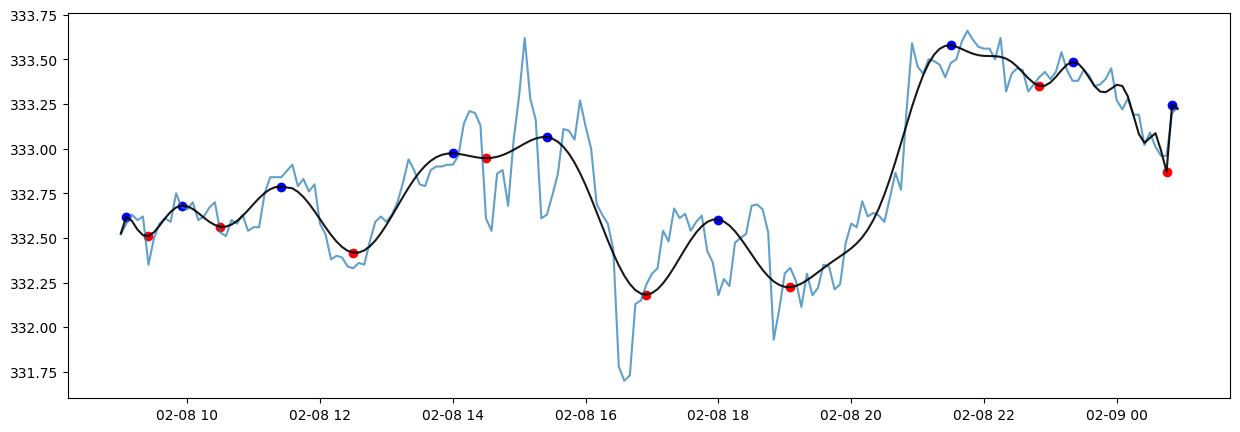

In [9]:
# Plot data
# Plot the stock data and identified minima

plt.figure(figsize=(15, 5))
plt.plot(stock_data.index, stock_data["close"], label='Close Prices', alpha=0.7)

# # Plot polynomial fit

plt.plot(stock_data.index[:min_length], y_polynomial_close, '-', markersize=1.0, color='black', alpha=0.9, label='Polynomial Fit')

# # Plot red dots at local minima and blue dots at local maxima

plt.scatter(stock_data.index[local_poly_minima], y_polynomial_close[local_poly_minima], color='red', label='Local Minima')
plt.scatter(stock_data.index[local_poly_maxima],y_polynomial_close[local_poly_maxima], color="blue", label = "Local Maxima")

In [10]:
# Define the time independent DF for double top/bottom identification
# Timestamp remains a column, but can identify pattern from peak to peak immediately

def time_independent_data(updated_stock_data):

    time_independent_df = []
    time_independent_df = pd.DataFrame(time_independent_df, columns = ["timestamp","close","high","low","trade_count","open","volume","vwap","poly_fit_open","poly_fit_high","poly_fit_low","poly_fit_close","minima","maxima","dbl_top_target","dbl_bot_target"])

    for index, row in islice(updated_stock_data.iterrows(), 0, None):

        # Assign to rows only those that contain local min or max

        if (updated_stock_data.at[index,"minima"] == -1):
            time_independent_df.loc[index] = row
            a = updated_stock_data.iloc[index]["poly_fit_close"]
        elif (updated_stock_data.at[index,"maxima"] == 1):
            time_independent_df.loc[index] = row
            a = updated_stock_data.iloc[index]["poly_fit_close"]

    # Reset time dependent index
    # Set new time independent index

    time_independent_df.reset_index(inplace = True)
    time_independent_df.rename(columns={"index":"time_dependent_index"}, inplace = True)

    return time_independent_df

time_independent_df = time_independent_data(updated_stock_data)

In [11]:
# Function to identify daily double top/bottom patterns
# Inherently there should only be 1 identification of the pattern as it is considered a trend reversal pattern
# The loop will break once the pattern is identified

def identify_double_patterns(time_independent_df, updated_stock_data):

    # Initialize variables to identify double top/bottom patterns
    # Time dependent variable x_0 will always begin at a local min/max which also coincides
    # With the start of a trend into a potential double top/bottom
    
    x_0 = 0

    # Initiation of double top/bottom variable
    
    a = 0

    # First peak/valley of double top/bottom pattern
    
    b = 0

    # Trough/peak of double top/bottom pattern

    c = 0

    # Second peak/vallye of double top/bottom pattern
    
    d = 0

    # Trigger of double top/bottom pattern
    
    e = 0

    # Final time increment to finalize and trigger double top signal
    
    x_f = 0

    # Read through code to identify double top/bottom and assign to target columns.

    for index, row in islice(time_independent_df.iterrows(), 0, len(time_independent_df) - 4):

        # Check for double top
        # If found then assigns x_f final time for writing to targets in time dependent dataframe

        if (time_independent_df.at[index,"minima"] == -1):
            a = time_independent_df.iloc[index]["poly_fit_close"]
            b = time_independent_df.iloc[index + 1]["poly_fit_close"]
            c = time_independent_df.iloc[index + 2]["poly_fit_close"]
            d = time_independent_df.iloc[index + 3]["poly_fit_close"]
            e = time_independent_df.iloc[index + 4]["poly_fit_close"]
            x_0 = time_independent_df.iloc[index]["time_dependent_index"]
            print(a)
            print(b)
            print(c)
            print(d)
            print(e)
            print(x_0)
            if (time_independent_df.iloc[index + 1]["poly_fit_low"]) < d < (time_independent_df.iloc[index + 1]["poly_fit_high"]) and (e < c):
                x_f = time_independent_df.iloc[index + 4]["time_dependent_index"]
                while (x_0 < x_f + 1):
                    updated_stock_data.at[x_0, "dbl_top_target"] = 1
                    x_0 = x_0 + 1
                break

        # Check for double bottom
        # If found then assigns x_f final time for writing to targets in time dependent dataframe
            
        elif (time_independent_df.at[index,"maxima"] == 1):
            a = time_independent_df.iloc[index]["poly_fit_close"]
            b = time_independent_df.iloc[index + 1]["poly_fit_close"]
            c = time_independent_df.iloc[index + 2]["poly_fit_close"]
            d = time_independent_df.iloc[index + 3]["poly_fit_close"]
            e = time_independent_df.iloc[index + 4]["poly_fit_close"]
            x_0 = time_independent_df.iloc[index]["time_dependent_index"] 
            print(a)
            print(b)
            print(c)
            print(d)
            print(e)
            print(x_0)
            if (time_independent_df.iloc[index + 1]["poly_fit_low"]) < d < (time_independent_df.iloc[index + 1]["poly_fit_high"]) and (e > c):
                x_f_min = time_independent_df.iloc[index + 4]["time_dependent_index"]
                while (x_0 < x_f + 1):
                    updated_stock_data.at[x_0, "dbl_bot_target"] = 1
                    x_0 = x_0 + 1
                break
            
    return updated_stock_data, x_f

updated_stock_data, x_f = identify_double_patterns(time_independent_df,updated_stock_data)

print(x_f)

332.61767218354595
332.5109490603135
332.6811523065765
332.5628037145764
332.78696382893395
1
0


In [12]:
# Data Checking

display(updated_stock_data.head(20))
print(updated_stock_data.loc[x_f])

,timestamp,close,high,low,trade_count,open,volume,vwap,poly_fit_open,poly_fit_high,poly_fit_low,poly_fit_close,minima,maxima,dbl_top_target,dbl_bot_target
0,2021-02-08 09:00:00+00:00,332.52,332.60,332.50,43,332.53,7077,332.551844,332.489827,332.608304,332.437786,332.525377,0,0,0,0
1,2021-02-08 09:05:00+00:00,332.58,332.62,332.47,26,332.53,5163,332.501669,332.639403,332.655607,332.629015,332.617672,0,1,0,0
2,2021-02-08 09:10:00+00:00,332.63,332.67,332.63,7,332.64,2992,332.638663,332.617785,332.629317,332.596708,332.595407,0,0,0,0
3,2021-02-08 09:15:00+00:00,332.60,332.65,332.56,15,332.60,2065,332.591991,332.547173,332.590511,332.500621,332.547431,0,0,0,0
4,2021-02-08 09:20:00+00:00,332.62,332.62,332.57,8,332.57,783,332.600204,332.488348,332.566576,332.420646,332.515065,0,0,0,0
5,2021-02-08 09:25:00+00:00,332.35,332.50,332.33,20,332.50,2942,332.450693,332.463893,332.564818,332.386758,332.510949,-1,0,0,0
6,2021-02-08 09:30:00+00:00,332.50,332.50,332.22,35,332.28,3173,332.361550,332.474605,332.581872,332.400265,332.532154,0,0,0,0
7,2021-02-08 09:35:00+00:00,332.58,332.59,332.52,14,332.53,3389,332.526117,332.510666,332.609922,332.448335,332.568906,0,0,0,0
8,2021-02-08 09:40:00+00:00,332.61,332.61,332.54,11,332.59,1287,332.580349,332.558850,332.640552,332.513433,332.610044,0,0,0,0
9,2021-02-08 09:45:00+00:00,332.59,332.67,332.59,14,332.65,3745,332.630774,332.606813,332.666866,332.578987,332.646110,0,0,0,0


timestamp         2021-02-08 09:00:00+00:00
close                                332.52
high                                  332.6
low                                   332.5
trade_count                              43
open                                 332.53
volume                                 7077
vwap                             332.551844
poly_fit_open                    332.489827
poly_fit_high                    332.608304
poly_fit_low                     332.437786
poly_fit_close                   332.525377
minima                                    0
maxima                                    0
dbl_top_target                            0
dbl_bot_target                            0
Name: 0, dtype: object


In [13]:
# Loop to collect and assess daily data one day at a time
# current_date = datetime.datetime.fromisoformat(end_date)
# next_day_date = current_date + datetime.timedelta(days=1)
master_df = {
    'timestamp': [],  # List of timestamps
    'close': [],      # List of close prices
    'high': [],       # List of high prices
    'low': [],        # List of low prices
    'trade_count': [], # List of trade counts
    'open': [],       # List of open prices
    'volume': [],     # List of volumes
    'vwap': [],       # List of volume-weighted average prices
    'poly_fit_open': [],    # List of polynomial fit open prices
    'poly_fit_high': [],    # List of polynomial fit high prices
    'poly_fit_low': [],     # List of polynomial fit low prices
    'poly_fit_close': [],   # List of polynomial fit close prices
    'minima': [],           # List of minima
    'maxima': [],           # List of maxima
    'dbl_top_target': [],   # List of double top targets
    'dbl_bot_target': []    # List of double bottom targets
}
master_df = pd.DataFrame(master_df)
# print(current_date)
# print(next_day_date)
# while current_date <= pd.Timestamp(end_date):
#    # Convert current_date to ISO format for API call
#    current_date_iso = current_date.isoformat()
#    # Calculate the next day
#    next_day_date = current_date + datetime.timedelta(days=1)
#    # Convert next_day_date to ISO format for API call
#    next_day_date_iso = next_day_date.isoformat()
#    # Fetch stock data for the current day
#    stock_data_current = get_stock_data(api, stock_symbol, time_frame, current_date_iso, next_day_date_iso)
#    updated_stock_data, min_length, y_polynomial_close, local_poly_minima, local_poly_maxima = polynomial_min_max_fit(stock_data, polynomial_degree)
#    time_independent_df = time_independent_data(updated_stock_data)
#    updated_stock_data, x_f = identify_double_patterns(time_independent_df, updated_stock_data)
#    # Perform your analysis or call your functions here
#    # e.g., identify_double_patterns(time_independent_df, updated_stock_data)
#    master_df = pd.concat([master_df,updated_stock_data])
#    # Increment to the next day
#    current_date = next_day_date

In [14]:

current_date = pd.Timestamp(end_date)
next_day_date = current_date + pd.Timedelta(days=1)

print(current_date)
print(next_day_date)

2021-02-09 00:00:00-05:00
2021-02-10 00:00:00-05:00


In [15]:
# Parameters for Stock Data from Alpacas
# Establish time frame (5 minute)

time_frame = "5min"

# Identify what stock symbol is trading

stock_symbol = "QQQ"

# Identify what start date to begin data analysis
# JAN 27 27 2021 GameStop event (GME) are we still doing this?

start_date_new = current_date.isoformat()

# Identify what end date to finalize data analysis

end_date_new = next_day_date.isoformat()

In [16]:
# Function to call daily stock data

#def get_stock_data(api, stock_symbol, time_frame, start_date, end_date):
    
    # Assuming api.get_bars returns a DataFrame with a 'df' attribute
    
stock_data_updated = api.get_bars(
    stock_symbol, 
    time_frame, 
    start=start_date_new, 
    end=end_date_new
    ).df
#    return stock_data_updated

#stock_data = get_stock_data(api, stock_symbol, time_frame, start_date, end_date)

# Displays the information pulled for working through code

stock_data_updated.info()
display(stock_data_updated.head())
display(stock_data_updated.tail())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 188 entries, 2021-02-09 09:00:00+00:00 to 2021-02-10 00:55:00+00:00
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   close        188 non-null    float64
 1   high         188 non-null    float64
 2   low          188 non-null    float64
 3   trade_count  188 non-null    int64  
 4   open         188 non-null    float64
 5   volume       188 non-null    int64  
 6   vwap         188 non-null    float64
dtypes: float64(5), int64(2)
memory usage: 11.8 KB


,close,high,low,trade_count,open,volume,vwap
timestamp,,,,,,,
2021-02-09 09:00:00+00:00,333.20,333.26,333.20,21,333.26,2999,333.240033
2021-02-09 09:05:00+00:00,333.09,333.22,333.05,24,333.22,3640,333.155632
2021-02-09 09:10:00+00:00,333.13,333.13,333.06,11,333.06,1180,333.110424
2021-02-09 09:15:00+00:00,333.15,333.16,333.14,6,333.16,512,333.146914
2021-02-09 09:20:00+00:00,333.10,333.10,333.05,7,333.05,713,333.083352


,close,high,low,trade_count,open,volume,vwap
timestamp,,,,,,,
2021-02-10 00:35:00+00:00,333.61,333.63,333.57,25,333.57,6993,333.596538
2021-02-10 00:40:00+00:00,333.60,333.68,333.57,19,333.68,3491,333.606846
2021-02-10 00:45:00+00:00,333.63,333.63,333.54,30,333.55,3910,333.577875
2021-02-10 00:50:00+00:00,333.63,333.63,333.60,31,333.60,5622,333.622560
2021-02-10 00:55:00+00:00,333.58,333.59,333.53,35,333.59,8848,333.576147


In [18]:
# Function to prepare daily stock data to identify double top/bottom patterns and prepare for targets
# Includes establishing a polynomial fit and assigning new columns for localized min/max

# Polynomial Degree

polynomial_degree = 75

def new_polynomial_min_max_fit(stock_data_updated, polynomial_degree):
    
    new_min_length = min(len(stock_data_updated.index), len(stock_data_updated['close']))
    new_x_data = np.arange(new_min_length)

    # Polynomial fitting
    new_polynomial_coefficients_open = np.polyfit(new_x_data, stock_data_updated['open'][:min_length], polynomial_degree)
    new_polynomial_coefficients_high = np.polyfit(new_x_data, stock_data_updated['high'][:min_length], polynomial_degree)
    new_polynomial_coefficients_low = np.polyfit(new_x_data, stock_data_updated['low'][:min_length], polynomial_degree)
    new_polynomial_coefficients_close = np.polyfit(new_x_data, stock_data_updated['close'][:min_length], polynomial_degree)

    # Evaluate the polynomial for plotting
    new_y_polynomial_open = np.polyval(new_polynomial_coefficients_open, new_x_data)
    new_y_polynomial_high = np.polyval(new_polynomial_coefficients_high, new_x_data)
    new_y_polynomial_low = np.polyval(new_polynomial_coefficients_low, new_x_data)
    new_y_polynomial_close = np.polyval(new_polynomial_coefficients_close, new_x_data)

    # Identify local extrema for polynomial fit data (minima and maxima)
    new_local_poly_minima = argrelextrema(new_y_polynomial_close, np.less, order=5)[0]
    new_local_poly_maxima = argrelextrema(new_y_polynomial_close, np.greater, order=5)[0]

    # Convert the close price polynomial fit data into a dataframe
    # This is done for OHLC poly fit data

    new_poly_df = pd.DataFrame(new_y_polynomial_open)
    columns = ['poly_fit_open']
    new_poly_df.columns = columns
    new_poly_df = new_poly_df.assign(poly_fit_high = new_y_polynomial_high)
    new_poly_df = new_poly_df.assign(poly_fit_low = new_y_polynomial_low)
    new_poly_df = new_poly_df.assign(poly_fit_close = new_y_polynomial_close)

    # Reset the index of the original updated ticker dataframe to concat with the polynomial dataframe that does not include a timeseries
    # This will ensure that the indexed intergers of the ploynomial fit align with the time each data point corresponds to

    updated_stock_data_new = stock_data_updated.reset_index()
    updated_stock_data_new = pd.concat([updated_stock_data_new, new_poly_df], axis='columns', join='inner')
    updated_stock_data_new.head()

    # Add minima and maxima column to the DataFrame

    updated_stock_data_new["minima"] = 0
    updated_stock_data_new["maxima"] = 0
    updated_stock_data_new.head()

    # Mark rows with local minima as 1 in the 'minima' column

    for index in new_local_poly_minima:
        updated_stock_data_new.at[index, 'minima'] = -1

    for index in new_local_poly_maxima:
        updated_stock_data_new.at[index, "maxima"] = 1

    # Create Target Columns - Double Top Target & Double Bottom Target
        
    updated_stock_data_new["dbl_top_target"] = 0
    updated_stock_data_new["dbl_bot_target"] = 0

    return updated_stock_data_new, new_min_length, new_y_polynomial_close, new_local_poly_minima, new_local_poly_maxima

updated_stock_data_new, new_min_length, new_y_polynomial_close, new_local_poly_minima, new_local_poly_maxima = new_polynomial_min_max_fit(stock_data_updated,polynomial_degree)

display(updated_stock_data_new.head(10))
display(updated_stock_data_new.tail(10))

c:\Users\JamesDavidson\Anaconda3\envs\mlenv\lib\site-packages\numpy\lib\polynomial.py:667: RuntimeWarning: overflow encountered in multiply
  scale = NX.sqrt((lhs*lhs).sum(axis=0))
c:\Users\JamesDavidson\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:49: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
C:\Users\JamesDavidson\AppData\Local\Temp\ipykernel_33436\3325137704.py:14: RankWarning: Polyfit may be poorly conditioned
  new_polynomial_coefficients_open = np.polyfit(new_x_data, stock_data_updated['open'][:min_length], polynomial_degree)
C:\Users\JamesDavidson\AppData\Local\Temp\ipykernel_33436\3325137704.py:15: RankWarning: Polyfit may be poorly conditioned
  new_polynomial_coefficients_high = np.polyfit(new_x_data, stock_data_updated['high'][:min_length], polynomial_degree)
C:\Users\JamesDavidson\AppData\Local\Temp\ipykernel_33436\3325137704.py:16: RankWarning: Polyfit may be poorly conditioned
  new_poly

,timestamp,close,high,low,trade_count,open,volume,vwap,poly_fit_open,poly_fit_high,poly_fit_low,poly_fit_close,minima,maxima,dbl_top_target,dbl_bot_target
0,2021-02-09 09:00:00+00:00,333.20,333.26,333.20,21,333.26,2999,333.240033,333.320688,333.318219,333.229054,333.229744,0,0,0,0
1,2021-02-09 09:05:00+00:00,333.09,333.22,333.05,24,333.22,3640,333.155632,333.130908,333.143780,333.057374,333.091925,0,0,0,0
2,2021-02-09 09:10:00+00:00,333.13,333.13,333.06,11,333.06,1180,333.110424,333.075143,333.110869,333.019862,333.075307,-1,0,0,0
3,2021-02-09 09:15:00+00:00,333.15,333.16,333.14,6,333.16,512,333.146914,333.084747,333.138022,333.045019,333.108792,0,0,0,0
4,2021-02-09 09:20:00+00:00,333.10,333.10,333.05,7,333.05,713,333.083352,333.118269,333.179741,333.090263,333.152530,0,0,0,0
5,2021-02-09 09:25:00+00:00,333.27,333.28,333.10,12,333.10,1010,333.226129,333.152938,333.213979,333.132745,333.187196,0,0,0,0
6,2021-02-09 09:30:00+00:00,333.21,333.28,333.21,18,333.26,2997,333.230891,333.178236,333.233057,333.162447,333.206156,0,0,0,0
7,2021-02-09 09:35:00+00:00,333.11,333.19,333.11,14,333.19,2185,333.153263,333.191177,333.237288,333.177139,333.209920,0,1,0,0
8,2021-02-09 09:40:00+00:00,333.08,333.08,333.08,13,333.08,4795,333.080079,333.192942,333.230682,333.178810,333.202368,0,0,0,0
9,2021-02-09 09:45:00+00:00,333.17,333.17,333.14,11,333.14,3900,333.153077,333.186588,333.218223,333.171254,333.188329,0,0,0,0


,timestamp,close,high,low,trade_count,open,volume,vwap,poly_fit_open,poly_fit_high,poly_fit_low,poly_fit_close,minima,maxima,dbl_top_target,dbl_bot_target
178,2021-02-10 00:10:00+00:00,333.57,333.59,333.51,27,333.55,4244,333.556861,333.578018,333.604330,333.530771,333.590116,0,0,0,0
179,2021-02-10 00:15:00+00:00,333.56,333.57,333.49,22,333.49,3991,333.518622,333.518700,333.561985,333.490586,333.554983,0,0,0,0
180,2021-02-10 00:20:00+00:00,333.56,333.57,333.55,13,333.55,2598,333.557552,333.496433,333.550298,333.479268,333.533384,-1,0,0,0
181,2021-02-10 00:25:00+00:00,333.62,333.66,333.58,24,333.61,3669,333.616250,333.542412,333.590199,333.515269,333.545987,0,0,0,0
182,2021-02-10 00:30:00+00:00,333.55,333.67,333.54,30,333.67,6249,333.569953,333.642970,333.668712,333.585246,333.594405,0,0,0,0
183,2021-02-10 00:35:00+00:00,333.61,333.63,333.57,25,333.57,6993,333.596538,333.711678,333.721238,333.626505,333.639645,0,0,0,0
184,2021-02-10 00:40:00+00:00,333.60,333.68,333.57,19,333.68,3491,333.606846,333.641555,333.672180,333.569578,333.622470,0,0,0,0
185,2021-02-10 00:45:00+00:00,333.63,333.63,333.54,30,333.55,3910,333.577875,333.495310,333.569595,333.480642,333.567302,0,0,0,0
186,2021-02-10 00:50:00+00:00,333.63,333.63,333.60,31,333.60,5622,333.622560,333.636159,333.665217,333.634730,333.662666,0,1,0,0
187,2021-02-10 00:55:00+00:00,333.58,333.59,333.53,35,333.59,8848,333.576147,333.583638,333.583993,333.524020,333.574610,0,0,0,0


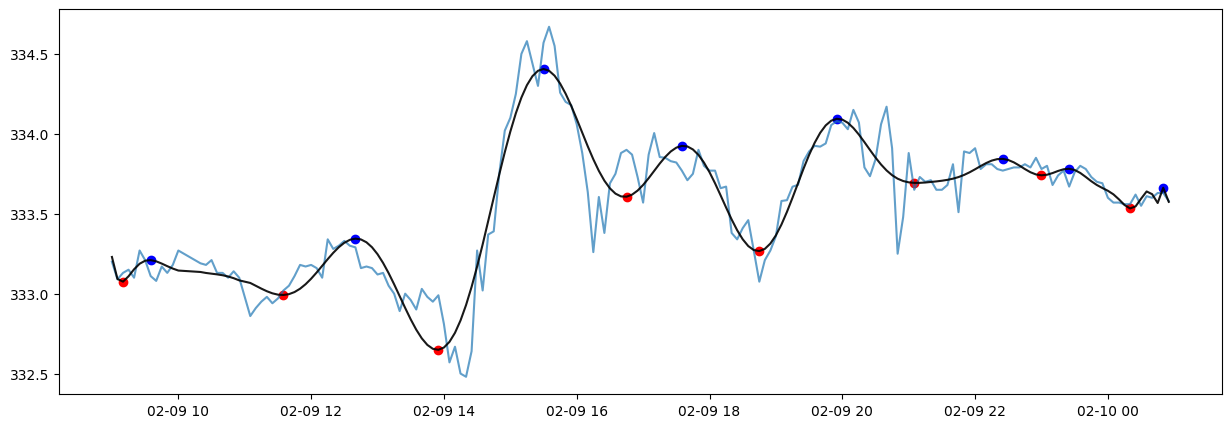

In [19]:
# Plot data
# Plot the stock data and identified minima

plt.figure(figsize=(15, 5))
plt.plot(stock_data_updated.index, stock_data_updated["close"], label='Close Prices', alpha=0.7)

# # Plot polynomial fit

plt.plot(stock_data_updated.index[:min_length], new_y_polynomial_close, '-', markersize=1.0, color='black', alpha=0.9, label='Polynomial Fit')

# # Plot red dots at local minima and blue dots at local maxima

plt.scatter(stock_data_updated.index[new_local_poly_minima], new_y_polynomial_close[new_local_poly_minima], color='red', label='Local Minima')
plt.scatter(stock_data_updated.index[new_local_poly_maxima], new_y_polynomial_close[new_local_poly_maxima], color="blue", label = "Local Maxima")

In [20]:
# Define the time independent DF for double top/bottom identification
# Timestamp remains a column, but can identify pattern from peak to peak immediately

def new_time_independent_data(updated_stock_data_new):

    new_time_independent_df = []
    new_time_independent_df = pd.DataFrame(new_time_independent_df, columns = ["timestamp","close","high","low","trade_count","open","volume","vwap","poly_fit_open","poly_fit_high","poly_fit_low","poly_fit_close","minima","maxima","dbl_top_target","dbl_bot_target"])

    for index, row in islice(updated_stock_data_new.iterrows(), 0, None):

        # Assign to rows only those that contain local min or max

        if (updated_stock_data_new.at[index,"minima"] == -1):
            new_time_independent_df.loc[index] = row
            a = updated_stock_data_new.iloc[index]["poly_fit_close"]
        elif (updated_stock_data_new.at[index,"maxima"] == 1):
            new_time_independent_df.loc[index] = row
            a = updated_stock_data_new.iloc[index]["poly_fit_close"]

    # Reset time dependent index
    # Set new time independent index

    new_time_independent_df.reset_index(inplace = True)
    new_time_independent_df.rename(columns={"index":"time_dependent_index"}, inplace = True)

    return new_time_independent_df

new_time_independent_df = new_time_independent_data(updated_stock_data_new)

In [21]:
# Function to identify daily double top/bottom patterns
# Inherently there should only be 1 identification of the pattern as it is considered a trend reversal pattern
# The loop will break once the pattern is identified

def new_identify_double_patterns(new_time_independent_df, updated_stock_data_new):

    # Initialize variables to identify double top/bottom patterns
    # Time dependent variable x_0 will always begin at a local min/max which also coincides
    # With the start of a trend into a potential double top/bottom
    
    x_0_1 = 0

    # Initiation of double top/bottom variable
    
    a_1 = 0

    # First peak/valley of double top/bottom pattern
    
    b_1 = 0

    # Trough/peak of double top/bottom pattern

    c_1 = 0

    # Second peak/vallye of double top/bottom pattern
    
    d_1 = 0

    # Trigger of double top/bottom pattern
    
    e_1 = 0

    # Final time increment to finalize and trigger double top signal
    
    x_f_1 = 0

    # Read through code to identify double top/bottom and assign to target columns.

    for index, row in islice(new_time_independent_df.iterrows(), 0, len(new_time_independent_df) - 4):

        # Check for double top
        # If found then assigns x_f final time for writing to targets in time dependent dataframe

        if (new_time_independent_df.at[index,"minima"] == -1):
            a_1 = new_time_independent_df.iloc[index]["poly_fit_close"]
            b_1 = new_time_independent_df.iloc[index + 1]["poly_fit_close"]
            c_1 = new_time_independent_df.iloc[index + 2]["poly_fit_close"]
            d_1 = new_time_independent_df.iloc[index + 3]["poly_fit_close"]
            e_1 = new_time_independent_df.iloc[index + 4]["poly_fit_close"]
            x_0_1 = new_time_independent_df.iloc[index]["time_dependent_index"]
            print(a_1)
            print(b_1)
            print(c_1)
            print(d_1)
            print(e_1)
            print(x_0_1)
            if (new_time_independent_df.iloc[index + 1]["poly_fit_low"]) < d_1 < (new_time_independent_df.iloc[index + 1]["poly_fit_high"]) and (e_1 < c_1):
                x_f_1 = new_time_independent_df.iloc[index + 4]["time_dependent_index"]
                while (x_0_1 < x_f_1 + 1):
                    updated_stock_data_new.at[x_0_1, "dbl_top_target"] = 1
                    x_0_1 = x_0_1 + 1
                break

        # Check for double bottom
        # If found then assigns x_f final time for writing to targets in time dependent dataframe
            
        elif (new_time_independent_df.at[index,"maxima"] == 1):
            a_1 = new_time_independent_df.iloc[index]["poly_fit_close"]
            b_1 = new_time_independent_df.iloc[index + 1]["poly_fit_close"]
            c_1 = new_time_independent_df.iloc[index + 2]["poly_fit_close"]
            d_1 = new_time_independent_df.iloc[index + 3]["poly_fit_close"]
            e_1 = new_time_independent_df.iloc[index + 4]["poly_fit_close"]
            x_0_1 = new_time_independent_df.iloc[index]["time_dependent_index"]
            print(a_1)
            print(b_1)
            print(c_1)
            print(d_1)
            print(e_1)
            print(x_0_1)
            if (new_time_independent_df.iloc[index + 1]["poly_fit_low"]) < d_1 < (new_time_independent_df.iloc[index + 1]["poly_fit_high"]) and (e_1 > c_1):
                x_f_min_1 = new_time_independent_df.iloc[index + 4]["time_dependent_index"]
                while (x_0_1 < x_f_1 + 1):
                    updated_stock_data_new.at[x_0_1, "dbl_bot_target"] = 1
                    x_0_1 = x_0_1 + 1
                break
            
    return updated_stock_data_new, x_f_1

updated_stock_data_new, x_f_1 = new_identify_double_patterns(new_time_independent_df,updated_stock_data_new)

print(x_f_1)

333.0753067678907
333.20991999514746
332.99183610693336
333.34437736426355
332.6488762795916
2
333.20991999514746
332.99183610693336
333.34437736426355
332.6488762795916
334.4057998102771
7
332.99183610693336
333.34437736426355
332.6488762795916
334.4057998102771
333.60693068344614
27
333.34437736426355
332.6488762795916
334.4057998102771
333.60693068344614
333.9247426402103
40
332.6488762795916
334.4057998102771
333.60693068344614
333.9247426402103
333.26662729832265
55
334.4057998102771
333.60693068344614
333.9247426402103
333.26662729832265
334.0943147406633
74
333.60693068344614
333.9247426402103
333.26662729832265
334.0943147406633
333.6933372573986
89
333.9247426402103
333.26662729832265
334.0943147406633
333.6933372573986
333.84328899498865
99
333.26662729832265
334.0943147406633
333.6933372573986
333.84328899498865
333.74069012909376
113
334.0943147406633
333.6933372573986
333.84328899498865
333.74069012909376
333.78146287966086
127
333.6933372573986
333.84328899498865
333.7406

In [22]:
# Data Checking

display(updated_stock_data_new.head(20))
print(updated_stock_data_new.loc[x_f_1])

,timestamp,close,high,low,trade_count,open,volume,vwap,poly_fit_open,poly_fit_high,poly_fit_low,poly_fit_close,minima,maxima,dbl_top_target,dbl_bot_target
0,2021-02-09 09:00:00+00:00,333.20,333.26,333.20,21,333.26,2999,333.240033,333.320688,333.318219,333.229054,333.229744,0,0,0,0
1,2021-02-09 09:05:00+00:00,333.09,333.22,333.05,24,333.22,3640,333.155632,333.130908,333.143780,333.057374,333.091925,0,0,0,0
2,2021-02-09 09:10:00+00:00,333.13,333.13,333.06,11,333.06,1180,333.110424,333.075143,333.110869,333.019862,333.075307,-1,0,0,0
3,2021-02-09 09:15:00+00:00,333.15,333.16,333.14,6,333.16,512,333.146914,333.084747,333.138022,333.045019,333.108792,0,0,0,0
4,2021-02-09 09:20:00+00:00,333.10,333.10,333.05,7,333.05,713,333.083352,333.118269,333.179741,333.090263,333.152530,0,0,0,0
5,2021-02-09 09:25:00+00:00,333.27,333.28,333.10,12,333.10,1010,333.226129,333.152938,333.213979,333.132745,333.187196,0,0,0,0
6,2021-02-09 09:30:00+00:00,333.21,333.28,333.21,18,333.26,2997,333.230891,333.178236,333.233057,333.162447,333.206156,0,0,0,0
7,2021-02-09 09:35:00+00:00,333.11,333.19,333.11,14,333.19,2185,333.153263,333.191177,333.237288,333.177139,333.209920,0,1,0,0
8,2021-02-09 09:40:00+00:00,333.08,333.08,333.08,13,333.08,4795,333.080079,333.192942,333.230682,333.178810,333.202368,0,0,0,0
9,2021-02-09 09:45:00+00:00,333.17,333.17,333.14,11,333.14,3900,333.153077,333.186588,333.218223,333.171254,333.188329,0,0,0,0


timestamp         2021-02-09 09:00:00+00:00
close                                 333.2
high                                 333.26
low                                   333.2
trade_count                              21
open                                 333.26
volume                                 2999
vwap                             333.240033
poly_fit_open                    333.320688
poly_fit_high                    333.318219
poly_fit_low                     333.229054
poly_fit_close                   333.229744
minima                                    0
maxima                                    0
dbl_top_target                            0
dbl_bot_target                            0
Name: 0, dtype: object


In [25]:
master_df = pd.concat([master_df,updated_stock_data])
master_df.head()

,timestamp,close,high,low,trade_count,open,volume,vwap,poly_fit_open,poly_fit_high,poly_fit_low,poly_fit_close,minima,maxima,dbl_top_target,dbl_bot_target
0,2021-02-08 09:00:00+00:00,332.52,332.60,332.50,43.0,332.53,7077.0,332.551844,332.489827,332.608304,332.437786,332.525377,0.0,0.0,0.0,0.0
1,2021-02-08 09:05:00+00:00,332.58,332.62,332.47,26.0,332.53,5163.0,332.501669,332.639403,332.655607,332.629015,332.617672,0.0,1.0,0.0,0.0
2,2021-02-08 09:10:00+00:00,332.63,332.67,332.63,7.0,332.64,2992.0,332.638663,332.617785,332.629317,332.596708,332.595407,0.0,0.0,0.0,0.0
3,2021-02-08 09:15:00+00:00,332.60,332.65,332.56,15.0,332.60,2065.0,332.591991,332.547173,332.590511,332.500621,332.547431,0.0,0.0,0.0,0.0
4,2021-02-08 09:20:00+00:00,332.62,332.62,332.57,8.0,332.57,783.0,332.600204,332.488348,332.566576,332.420646,332.515065,0.0,0.0,0.0,0.0


In [26]:
type(master_df)

pandas.core.frame.DataFrame

In [28]:
master_df = pd.concat([master_df, updated_stock_data_new])
display(master_df.head(10))
display(master_df.tail(10))

,timestamp,close,high,low,trade_count,open,volume,vwap,poly_fit_open,poly_fit_high,poly_fit_low,poly_fit_close,minima,maxima,dbl_top_target,dbl_bot_target
0,2021-02-08 09:00:00+00:00,332.52,332.60,332.50,43.0,332.53,7077.0,332.551844,332.489827,332.608304,332.437786,332.525377,0.0,0.0,0.0,0.0
1,2021-02-08 09:05:00+00:00,332.58,332.62,332.47,26.0,332.53,5163.0,332.501669,332.639403,332.655607,332.629015,332.617672,0.0,1.0,0.0,0.0
2,2021-02-08 09:10:00+00:00,332.63,332.67,332.63,7.0,332.64,2992.0,332.638663,332.617785,332.629317,332.596708,332.595407,0.0,0.0,0.0,0.0
3,2021-02-08 09:15:00+00:00,332.60,332.65,332.56,15.0,332.60,2065.0,332.591991,332.547173,332.590511,332.500621,332.547431,0.0,0.0,0.0,0.0
4,2021-02-08 09:20:00+00:00,332.62,332.62,332.57,8.0,332.57,783.0,332.600204,332.488348,332.566576,332.420646,332.515065,0.0,0.0,0.0,0.0
5,2021-02-08 09:25:00+00:00,332.35,332.50,332.33,20.0,332.50,2942.0,332.450693,332.463893,332.564818,332.386758,332.510949,-1.0,0.0,0.0,0.0
6,2021-02-08 09:30:00+00:00,332.50,332.50,332.22,35.0,332.28,3173.0,332.361550,332.474605,332.581872,332.400265,332.532154,0.0,0.0,0.0,0.0
7,2021-02-08 09:35:00+00:00,332.58,332.59,332.52,14.0,332.53,3389.0,332.526117,332.510666,332.609922,332.448335,332.568906,0.0,0.0,0.0,0.0
8,2021-02-08 09:40:00+00:00,332.61,332.61,332.54,11.0,332.59,1287.0,332.580349,332.558850,332.640552,332.513433,332.610044,0.0,0.0,0.0,0.0
9,2021-02-08 09:45:00+00:00,332.59,332.67,332.59,14.0,332.65,3745.0,332.630774,332.606813,332.666866,332.578987,332.646110,0.0,0.0,0.0,0.0


,timestamp,close,high,low,trade_count,open,volume,vwap,poly_fit_open,poly_fit_high,poly_fit_low,poly_fit_close,minima,maxima,dbl_top_target,dbl_bot_target
178,2021-02-10 00:10:00+00:00,333.57,333.59,333.51,27.0,333.55,4244.0,333.556861,333.578018,333.604330,333.530771,333.590116,0.0,0.0,0.0,0.0
179,2021-02-10 00:15:00+00:00,333.56,333.57,333.49,22.0,333.49,3991.0,333.518622,333.518700,333.561985,333.490586,333.554983,0.0,0.0,0.0,0.0
180,2021-02-10 00:20:00+00:00,333.56,333.57,333.55,13.0,333.55,2598.0,333.557552,333.496433,333.550298,333.479268,333.533384,-1.0,0.0,0.0,0.0
181,2021-02-10 00:25:00+00:00,333.62,333.66,333.58,24.0,333.61,3669.0,333.616250,333.542412,333.590199,333.515269,333.545987,0.0,0.0,0.0,0.0
182,2021-02-10 00:30:00+00:00,333.55,333.67,333.54,30.0,333.67,6249.0,333.569953,333.642970,333.668712,333.585246,333.594405,0.0,0.0,0.0,0.0
183,2021-02-10 00:35:00+00:00,333.61,333.63,333.57,25.0,333.57,6993.0,333.596538,333.711678,333.721238,333.626505,333.639645,0.0,0.0,0.0,0.0
184,2021-02-10 00:40:00+00:00,333.60,333.68,333.57,19.0,333.68,3491.0,333.606846,333.641555,333.672180,333.569578,333.622470,0.0,0.0,0.0,0.0
185,2021-02-10 00:45:00+00:00,333.63,333.63,333.54,30.0,333.55,3910.0,333.577875,333.495310,333.569595,333.480642,333.567302,0.0,0.0,0.0,0.0
186,2021-02-10 00:50:00+00:00,333.63,333.63,333.60,31.0,333.60,5622.0,333.622560,333.636159,333.665217,333.634730,333.662666,0.0,1.0,0.0,0.0
187,2021-02-10 00:55:00+00:00,333.58,333.59,333.53,35.0,333.59,8848.0,333.576147,333.583638,333.583993,333.524020,333.574610,0.0,0.0,0.0,0.0
